<a href="https://colab.research.google.com/github/prabal5ghosh/Autonomous-Taxi-Agent-game-using-Q-learning-SARSA-and-Deep-Q-learning/blob/main/Autonomous_Taxi_Agent_game__1_prabal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Choose algorithm (q_learning, sarsa, dqn): q_learning
Training Q-learning agent...


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


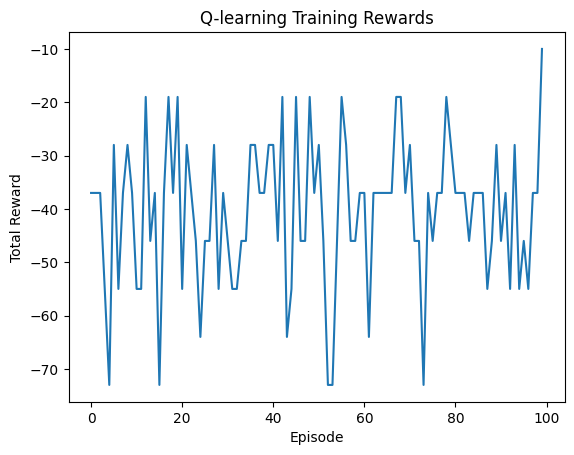

Q-learning Evaluation Mean Reward: -14.05


In [9]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import random

# For DQN (Deep Q-Learning)
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Set random seeds for reproducibility
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

###############################
# Q-LEARNING IMPLEMENTATION
###############################
def train_q_learning(env, num_episodes=100, max_steps=10, alpha=0.1, gamma=0.99,
                     epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        # The change is here: handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result

        total_reward = 0

        for step in range(max_steps):
            # Epsilon-greedy action selection
            if np.random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q_table[state, :])

            # The change is here: handle cases where env.step() returns 4 or 5 values
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False  # Assuming truncated is not relevant in this case
            else:
                next_state, reward, terminated, truncated, _ = step_result
            #done = terminated or truncated  # This line is now redundant

            # Q-learning update: using max over next state's actions
            Q_table[state, action] = (1 - alpha) * Q_table[state, action] + \
                                     alpha * (reward + gamma * np.max(Q_table[next_state, :]))

            state = next_state
            total_reward += reward
            if terminated or truncated: #Change here to check for either termination or truncation
                break

        rewards_all_episodes.append(total_reward)
        # Decay epsilon after each episode
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    return Q_table, rewards_all_episodes



###############################
# SARSA IMPLEMENTATION
###############################

def train_sarsa(env, num_episodes=100, max_steps=10, alpha=0.1, gamma=0.99,
                epsilon=1.0, min_epsilon=0.01, decay_rate=0.001):
    Q_table = np.zeros((env.observation_space.n, env.action_space.n))
    rewards_all_episodes = []

    for episode in range(num_episodes):
        # The change is here: handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result  # Handle the usual case with a tuple

        total_reward = 0

        # Choose initial action with epsilon-greedy
        if np.random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_table[state, :])

        for step in range(max_steps):
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Choose next action using epsilon-greedy
            if np.random.uniform(0, 1) < epsilon:
                next_action = env.action_space.sample()
            else:
                next_action = np.argmax(Q_table[next_state, :])

            # SARSA update rule
            Q_table[state, action] += alpha * (reward + gamma * Q_table[next_state, next_action] - Q_table[state, action])

            state = next_state
            action = next_action
            total_reward += reward
            if done:
                break

        rewards_all_episodes.append(total_reward)
        # Decay epsilon after each episode
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)

    return Q_table, rewards_all_episodes

###############################
# DQN (Deep Q-Learning) IMPLEMENTATION
###############################

# Define a simple neural network to approximate Q-values.
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.out = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

# Replay Memory to store experience tuples
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

def one_hot(state, state_size):
    vec = np.zeros(state_size)
    vec[state] = 1.0
    return vec

def train_dqn(env, num_episodes=100, max_steps=10, gamma=0.99,
              epsilon=1.0, min_epsilon=0.1, decay_rate=0.001, lr=0.001,
              batch_size=64, memory_capacity=10000, target_update=10):
    state_size = env.observation_space.n
    action_size = env.action_space.n

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    policy_net = DQN(state_size, action_size).to(device)
    target_net = DQN(state_size, action_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayMemory(memory_capacity)
    rewards_all_episodes = []
    steps_done = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        state_vec = one_hot(state, state_size)
        total_reward = 0

        for t in range(max_steps):
            # Epsilon-greedy action selection
            eps_threshold = min_epsilon + (epsilon - min_epsilon) * np.exp(-decay_rate * steps_done)
            steps_done += 1
            if random.random() < eps_threshold:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state_vec = one_hot(next_state, state_size)
            memory.push(state_vec, action, reward, next_state_vec, done)
            state_vec = next_state_vec
            total_reward += reward

            # Learn only if enough samples have been collected
            if len(memory) >= batch_size:
                batch = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)

                batch_state = torch.FloatTensor(batch_state).to(device)
                batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                current_q = policy_net(batch_state).gather(1, batch_action)
                next_q = target_net(batch_next_state).max(1)[0].unsqueeze(1).detach()
                expected_q = batch_reward + (gamma * next_q * (1 - batch_done))

                loss = nn.MSELoss()(current_q, expected_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if done:
                break

        rewards_all_episodes.append(total_reward)
        # Update target network periodically
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

    return policy_net, rewards_all_episodes

###############################
# EVALUATION FUNCTIONS
###############################
def evaluate_policy(env, Q_table, num_episodes=100, max_steps=10):
    total_rewards = []
    for episode in range(num_episodes):
        # The change is here to handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result  # Handle the usual case with a tuple

        episode_reward = 0
        for t in range(max_steps):
            action = np.argmax(Q_table[state, :])
            # The change is here: handling different return values from env.step()
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
                terminated = done
                truncated = False
            else:
                next_state, reward, terminated, truncated, _ = step_result

            episode_reward += reward
            state = next_state
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    return mean_reward

def evaluate_dqn(env, policy_net, num_episodes=100, max_steps=10):
    state_size = env.observation_space.n
    total_rewards = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    for episode in range(num_episodes):
        # The change is here to handle cases where env.reset() returns int or tuple
        reset_result = env.reset()
        if isinstance(reset_result, int):
            state = reset_result
        else:
            state, _ = reset_result  # Handle the usual case with a tuple

        state_vec = one_hot(state, state_size)
        episode_reward = 0
        for t in range(max_steps):
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state_vec).unsqueeze(0).to(device)
                q_values = policy_net(state_tensor)
                action = q_values.argmax().item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state_vec = one_hot(next_state, state_size)
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    mean_reward = np.mean(total_rewards)
    return mean_reward

###############################
# MAIN FUNCTION
###############################

def main():
    # Create the Taxi-v3 environment with RGB rendering (for consistency with Gym v0.26+)
    env = gym.make("Taxi-v3", render_mode="rgb_array")

    algorithm = input("Choose algorithm (q_learning, sarsa, dqn): ").strip().lower()

    if algorithm == "q_learning":
        print("Training Q-learning agent...")
        Q_table, rewards = train_q_learning(env)
        plt.plot(rewards)
        plt.title("Q-learning Training Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()
        mean_reward = evaluate_policy(env, Q_table)
        print(f"Q-learning Evaluation Mean Reward: {mean_reward:.2f}")

    elif algorithm == "sarsa":
        print("Training SARSA agent...")
        Q_table, rewards = train_sarsa(env)
        plt.plot(rewards)
        plt.title("SARSA Training Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()
        mean_reward = evaluate_policy(env, Q_table)
        print(f"SARSA Evaluation Mean Reward: {mean_reward:.2f}")

    elif algorithm == "dqn":
        print("Training DQN agent...")
        policy_net, rewards = train_dqn(env)
        plt.plot(rewards)
        plt.title("DQN Training Rewards")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()
        mean_reward = evaluate_dqn(env, policy_net)
        print(f"DQN Evaluation Mean Reward: {mean_reward:.2f}")

    else:
        print("Unknown algorithm selected.")

    env.close()

if __name__ == "__main__":
    main()
